Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. Внимание! выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

​
Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

​
__Задание 1:__
сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.
​

__Задание 2:__
сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.
​

__Задание 3:__
построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.
​

__Задание 4:__
выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.
​

__Задание 5:__
сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.
​

__Задание 6 (опциональное):__
сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
​

__Задание 7 (совсем опциональное):__
в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [1]:
from typing import List, Optional, Tuple
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)

In [3]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_test.csv'

In [6]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_train.csv'

In [7]:
data = pd.read_csv(train_path)

In [8]:
test = pd.read_csv(test_path)

In [9]:
target = data["isFraud"]
data = data.drop(["isFraud"], axis=1)

numerical_features_train = data.select_dtypes(include=np.number)
categorical_features_train = data.select_dtypes(include=["object"])

In [10]:
numerical_features_test = test.select_dtypes(include=np.number)
categorical_features_test = test.select_dtypes(include=["object"])

In [11]:
data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
def categorical_transformation(df, categorical_features):

  Product_CD_dict = {
    'W': 1, 
    'H': 2, 
    'C': 3, 
    'S': 4, 
    'R': 5}

  df['ProductCD_ord'] = df.ProductCD.map(Product_CD_dict)

  df['card4'] = df.card4.fillna('unknown')
  Card4_dict = {
    'discover': 1, 
    'mastercard': 2, 
    'visa': 3, 
    'american express': 4, 
    'unknown': 5
}
  df['card4_ord'] = df.card4.map(Card4_dict)

  df['card6'] = df.card6.fillna('unknown')
  Card6_dict = {
    'credit': 1, 
    'debit': 2, 
    'debit or credit': 3, 
    'charge card': 4, 
    'unknown': 5
}
  df['card6_ord'] = df.card6.map(Card6_dict)

  df['P_emaildomain'] = df.P_emaildomain.fillna('unknown')
  df['P_emaildomain_ord'] = LabelEncoder().fit_transform(df.P_emaildomain)

  df['R_emaildomain'] = df.R_emaildomain.fillna('unknown')
  df['R_emaildomain_ord'] = LabelEncoder().fit_transform(df.R_emaildomain)

  M_dict = {
    'F':0,
    'T':1,
    'unknown':-1
}
  M4_dict = {
    'M2':3,
    'M0':4,
    'unknown':6,
    'M1':5
}
  df['M4'] = df.M4.fillna('unknown')
  df['M4_ord'] = df.M4.map(M4_dict)

  M_features = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
  for feature in M_features: 
    df[feature] = df[feature].fillna('unknown')
    df[feature + '_ord'] = df[feature].map(M_dict)
  
  upd_features = categorical_features.columns.to_list()
  upd_features = [i+'_ord' for i in categorical_features.columns.to_list()]

  return df[upd_features]

In [13]:
cat_data_train = categorical_transformation(data[categorical_features_train.columns.to_list()], categorical_features_train)
cat_test = categorical_transformation(test[categorical_features_test.columns.to_list()], categorical_features_test)

In [14]:
#Пересоберем трейн и тест после преобразований. 

In [15]:
data = numerical_features_train.join(cat_data_train)

In [16]:
test = numerical_features_test.join(cat_test)

In [17]:
y_lead = test['isFraud']
x_lead = test.drop('isFraud', axis=1)

## Задание 1. 

In [18]:
x_train, x_test = train_test_split(
    data, train_size=0.75, shuffle=True, random_state=13,
)
y_train, y_test = train_test_split(
    target, train_size=0.75, shuffle=True, random_state=13,
)

In [19]:
lgb_params = { 
    'boosting_type': 'gbdt',
    'n_estimators': 1500,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

In [20]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    X=x_train, 
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=50
)

Training until validation scores don't improve for 25 rounds.
[50]	dtrain's auc: 0.934565	dtrain's binary_logloss: 0.0628364	dvalid's auc: 0.922149	dvalid's binary_logloss: 0.069085
[100]	dtrain's auc: 0.960769	dtrain's binary_logloss: 0.0515746	dvalid's auc: 0.937555	dvalid's binary_logloss: 0.0614152
[150]	dtrain's auc: 0.971907	dtrain's binary_logloss: 0.0450918	dvalid's auc: 0.945077	dvalid's binary_logloss: 0.0576543
[200]	dtrain's auc: 0.978922	dtrain's binary_logloss: 0.0406625	dvalid's auc: 0.95023	dvalid's binary_logloss: 0.0552162
[250]	dtrain's auc: 0.984152	dtrain's binary_logloss: 0.0368299	dvalid's auc: 0.953052	dvalid's binary_logloss: 0.0533555
[300]	dtrain's auc: 0.987536	dtrain's binary_logloss: 0.0339931	dvalid's auc: 0.955158	dvalid's binary_logloss: 0.0520818
[350]	dtrain's auc: 0.989804	dtrain's binary_logloss: 0.0314757	dvalid's auc: 0.956797	dvalid's binary_logloss: 0.0508812
[400]	dtrain's auc: 0.991765	dtrain's binary_logloss: 0.0290907	dvalid's auc: 0.958047	

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.508716, importance_type='split',
               is_unbalance=False, learning_rate=0.05134, max_depth=10,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.024766, n_estimators=1500, n_jobs=-1,
               num_leaves=54, objective=None, random_state=27,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, subsample_freq=0,
               verbose=-1)

In [21]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model.predict_proba(x_lead)[:, 1]), 3)}")

ROC AUC train = 0.997
ROC AUC test = 0.962
ROC AUC leaderboard = 0.859


In [22]:
# При данном виде разбивке мы наблюдаем явное переобучение на трейне, так как значение ROC-AUC сильно выше лидерборда. 

## Задание 2. 

In [23]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=1,
)


x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=42
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=42
)

In [24]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 393 cols
x_valid.shape = 37800 rows, 393 cols
x_test.shape = 16201 rows, 393 cols


In [25]:
lgb_params = { 
    'boosting_type': 'gbdt',
    'n_estimators': 1500,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

In [26]:
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(
    X=x_train, 
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_names=["dtrain", "dvalid"],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=50
)

Training until validation scores don't improve for 25 rounds.
[50]	dtrain's auc: 0.936683	dtrain's binary_logloss: 0.0627026	dvalid's auc: 0.914338	dvalid's binary_logloss: 0.0688648
[100]	dtrain's auc: 0.963411	dtrain's binary_logloss: 0.051056	dvalid's auc: 0.931173	dvalid's binary_logloss: 0.0613392
[150]	dtrain's auc: 0.97516	dtrain's binary_logloss: 0.0445299	dvalid's auc: 0.938884	dvalid's binary_logloss: 0.0578105
[200]	dtrain's auc: 0.98209	dtrain's binary_logloss: 0.0397076	dvalid's auc: 0.943271	dvalid's binary_logloss: 0.0554808
[250]	dtrain's auc: 0.986516	dtrain's binary_logloss: 0.0360627	dvalid's auc: 0.946311	dvalid's binary_logloss: 0.0540019
[300]	dtrain's auc: 0.989554	dtrain's binary_logloss: 0.0329907	dvalid's auc: 0.948711	dvalid's binary_logloss: 0.0527529
[350]	dtrain's auc: 0.992344	dtrain's binary_logloss: 0.0300151	dvalid's auc: 0.950313	dvalid's binary_logloss: 0.0517318
[400]	dtrain's auc: 0.993906	dtrain's binary_logloss: 0.0276843	dvalid's auc: 0.951657	d

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.508716, importance_type='split',
               is_unbalance=False, learning_rate=0.05134, max_depth=10,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.024766, n_estimators=1500, n_jobs=-1,
               num_leaves=54, objective=None, random_state=27,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, subsample_freq=0,
               verbose=-1)

In [28]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_lgb.predict_proba(x_train)[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_valid, model_lgb.predict_proba(x_valid)[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_test, model_lgb.predict_proba(x_test)[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_lgb.predict_proba(x_lead)[:, 1]), 3)}")

ROC AUC train = 0.998
ROC AUC valid = 0.956
ROC AUC test = 0.955
ROC AUC leaderboard = 0.856


In [29]:
# Снова видим явное сильное переобучение на трейне. На valid и test выборке данные чуть получше, но по сравнению с лидербордом совсем плохо. Hold-out валидация
# на три выборки также неустойчива из-за высокой разницы roc-auc на этих выборках 

## Задание 3. 

In [30]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

__Train__

In [31]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_train, model_lgb.predict_proba(x_train)[:, 1], roc_auc_score)

print(calculate_confidence_interval(scores), 
      f"ROC AUC train = {round(roc_auc_score(y_train, model_lgb.predict_proba(x_train)[:, 1]), 3)}")

(0.9980858129295959, 0.99883377237893) ROC AUC train = 0.998


__Valid__

In [32]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_valid, model_lgb.predict_proba(x_valid)[:, 1], roc_auc_score)

print(calculate_confidence_interval(scores), 
      f"ROC AUC test = {round(roc_auc_score(y_valid, model_lgb.predict_proba(x_valid)[:, 1]), 3)}")

(0.9481823016186011, 0.9627325348483393) ROC AUC test = 0.956


__Test__

In [33]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model_lgb.predict_proba(x_test)[:, 1], roc_auc_score)

print(calculate_confidence_interval(scores), 
      f"ROC AUC valid = {round(roc_auc_score(y_test, model_lgb.predict_proba(x_test)[:, 1]), 3)}")

(0.9430925939134442, 0.9671913069201341) ROC AUC valid = 0.955


__Leaderboard__

In [34]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_lead, model_lgb.predict_proba(x_lead)[:, 1], roc_auc_score)

print(calculate_confidence_interval(scores), 
      f"ROC AUC leaderboard = ",
    round(roc_auc_score(y_lead, model_lgb.predict_proba(x_lead)[:, 1]), 3))

(0.8493737251926111, 0.8625786317121134) ROC AUC leaderboard =  0.856


In [35]:
# roc auc leaderboard лежит внутри доверительного интервала

In [36]:
abs(0.849-0.862)/0.8555

0.015195791934541217

## Задание 4. 

__Adversarial validation__

In [37]:
x_adv = pd.concat([
    x_train, x_lead], axis=0
)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(x_lead.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [38]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
y_pred_adv = model.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


In [40]:
y_pred = model.predict_proba(x_train)


In [41]:
# отбираем наблюдение с "большой" вероятностью y_pred
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    125999
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

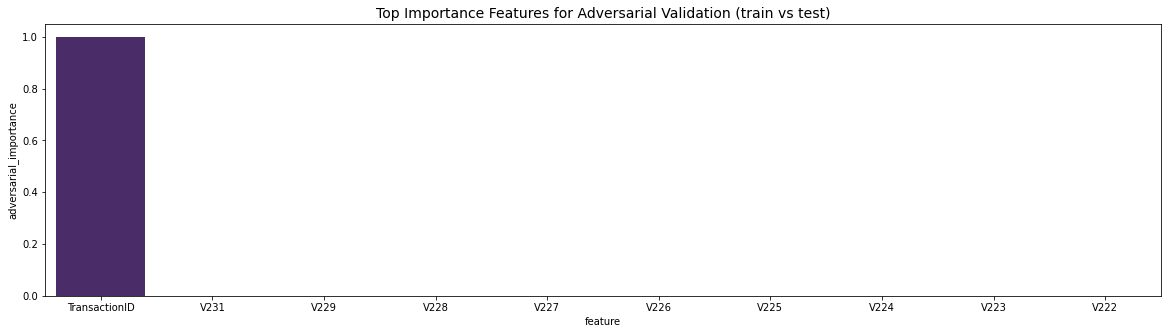

In [42]:
importance = pd.DataFrame({
    "feature": x_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [43]:
#из обучающей выборки нет похожих наблюдений на LB выборку. Возможно, есть смысл рассмотреть валидацию по 'TransactionID'

## Задание 5. 


In [44]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [48]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, target, model_lgb, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.975, valid-score = 0.6394
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.9772, valid-score = 0.6967
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.9734, valid-score = 0.7543
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.9761, valid-score = 0.7245
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.9731, valid-score = 0.6999
CV-results train: 0.975 +/- 0.002
CV-results valid: 0.7029 +/- 0.038
OOF-score = 0.7003


In [49]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_lead, y_lead, model_lgb, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 80000, valid-observations = 20001
train-score = 0.9771, valid-score = 0.6819
Fold: 2, train-observations = 80001, valid-observations = 20000
train-score = 0.9788, valid-score = 0.6869
Fold: 3, train-observations = 80001, valid-observations = 20000
train-score = 0.9757, valid-score = 0.6714
Fold: 4, train-observations = 80001, valid-observations = 20000
train-score = 0.9739, valid-score = 0.7219
Fold: 5, train-observations = 80001, valid-observations = 20000
train-score = 0.974, valid-score = 0.718
CV-results train: 0.9759 +/- 0.002
CV-results valid: 0.696 +/- 0.02
OOF-score = 0.6983


In [50]:
#кросс-валидация устойчивая, потому что дисперсия на лидерборде и на тренировочной выборке небольшая. 